# **Optimizing Agentic Feature Extractor Configuration for Cost and Quality Efficiency**



## **Introduction**

In this notebook, we aim to identify the optimal configuration for the `AgenticFeatureExtractor` by experimenting with different values of `max_missing_feature_attempts` and `max_low_confidence_attempts`. Our goal is to balance the cost and time of feature extraction with the quality of the extracted data.

We will:

- Run the agent on a sample dataset with various configurations.
- Collect metrics such as cost, time taken, and data quality.
- Visualize and analyze the results to determine the optimal configuration.

---


## **1. Preparation**

### **1.1 Import Libraries and Modules**

First, we import all necessary libraries and set up configurations for logging, display options, and visual styles.


In [1]:
import os
import sys
import ast
import logging
import asyncio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell

# Set up display options and styles
sns.set()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.float_format', '{:.2f}'.format)
InteractiveShell.ast_node_interactivity = 'all'

# Configure logging
logging.basicConfig(level=logging.ERROR, force=True)

### **1.2 Set Up Project Environment**

We add the project root to the system path to import custom modules.


In [2]:
# Set up project root and import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

### **4.3 Load data**

We convert the results into a DataFrame and save them for further analysis.


In [3]:
results_df = pd.read_csv("../data/results_df.csv")

results_df.info()
results_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               90 non-null     object
 1   config           90 non-null     object
 2   extracted_data   90 non-null     object
 3   usage_data       90 non-null     object
 4   raw_data_length  90 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.6+ KB


,id,config,extracted_data,usage_data,raw_data_length
0,EmNANO-i2300-E3825,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}","{'name': 'EMNANOIE', 'manufacturer': 'ARBOR TECHNOLOGY', 'form_factor': 'COM Express Mini', 'evaluation_or_commercialization': True, 'processor_architecture': 'x86', 'processor_core_count': 'Not Available', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'Not Available', 'memory': '4GB DDR3L SDRAM', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4 x USB ports', '1 x USB port', '2 x Serial Ports', '2 x PCIe x1 Gen2 lanes', '1 x SPI', '1 x LPC', '2 x Serial ATA ports', '1 x SDIO', '1 x I2C', '1 x HD Audio'], 'wireless': 'Not Available', 'operating_system_bsp': 'Not Available', 'operating_temperature_max': 'Not Available', 'operating_temperature_min': 'Not Available', 'certifications': 'Not Available', 'short_summary': 'Intel Atom E series processor COM Express Mini Type CPU Module with soldered onboard Intel Atom E series SoC processor.', 'full_summary': 'The EMNANOIE is a COM Express Mini Type CPU Module featuring an Intel Atom E series processor, integrated Gigabit Ethernet, dual independent display support, and extended operating temperature range.', 'full_product_description': 'The EMNANOIE is a COM Express Mini Type CPU Module powered by an Intel Atom E series processor. It includes soldered onboard 4GB DDR3L SDRAM, integrated Gigabit Ethernet, multiple USB and serial ports, PCIe lanes, SPI, LPC, and SATA interfaces. It supports dual independent displays with DDI and LVDS ports, and operates within an extended temperature range.', 'target_applications': 'Not Available'}","{'extract_features': [{'input_tokens': 1087, 'output_tokens': 738, 'time_taken': 7.602741003036499}], 'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 2.7111527919769287}]}",2003
1,conga-B7XDslashP-D1508,"{'max_missing_feature_attempts': 0, 'max_low_confidence_attempts': 0}","{'name': 'CONGABXD', 'manufacturer': 'CONGATEC', 'form_factor': 'COM EXPRESS BASIC 125 X 95 MM', 'evaluation_or_commercialization': False, 'processor_architecture': 'X86', 'processor_core_count': 'UP TO 16 CORES', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'UP TO 65W', 'memory': 'DUAL CHANNEL DDR4 2400 MT/S, UP TO 64GB, ECC SUPPORT', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4x USB 3.0', '8x USB 2.0', '4x SATA III', '1x LPC', '1x SPI', '1x I2C', '2x UART', '1x SMBus', '2x GbE KR'], 'wireless': 'Not Available', 'operating_system_bsp': ['WINDOWS 10', 'WINDOWS SERVER 2016', 'WINDOWS SERVER 2019', 'RHEL', 'SUSE', 'FEDORA', 'UBUNTU', 'CENTOS', 'FREEBSD', 'VMWARE', 'HYPERV', 'XEN', 'ESXI'], 'operating_temperature_max': '85°C', 'operating_temperature_min': '-40°C', 'certifications': 'Not Available', 'short_summary': 'COM Express Type 7 module with Intel Xeon D processors, up to 16 cores, dual channel DDR4 memory, and extensive I/O options.', 'full_summary': 'The conga-BXD is a COM Express Type 7 module featuring Intel Xeon D processors with up to 16 cores, dual channel DDR4 memory with ECC support, and a wide range of I/O interfaces including USB, SATA, PCIe, and Ethernet. It is designed for industrial and server-class applications with extended temperature ranges.', 'full_product_description': 'The conga-BXD COM Express Type 7 module is equipped with Intel Xeon D processors, offering up to 16 cores and 65W TDP. It supports dual channel DDR4 2400 MT/s memory up to 64GB with ECC. The module includes extensive I/O options such as 4x USB 3.0, 8x USB 2.0, 4x SATA III, 2x GbE KR, and various other interfaces. It is suitable for industrial and server-class applications, supporting a wide range of operating systems and featuring robust management and security capabilities.', 'target_applications': ['INDUSTRIAL AUTOMATION', 'SERVER-CLASS APPLICATIONS', 'NETWORKING', 'TELECOMMUNICATIONS', 'EDGE COMPUTING']}","{'extract_features': [{'inp


---


In [4]:
# Print the first few entries of the "extracted_data" column
print(results_df["extracted_data"].head())

# Print the data type of the first entry
print(type(results_df["extracted_data"].iloc[0]))

0                                                                                                                                                                                                                                                                                                                                                                                                                                                         {'name': 'EMNANOIE', 'manufacturer': 'ARBOR TECHNOLOGY', 'form_factor': 'COM Express Mini', 'evaluation_or_commercialization': True, 'processor_architecture': 'x86', 'processor_core_count': 'Not Available', 'processor_manufacturer': 'INTEL', 'processor_tdp': 'Not Available', 'memory': '4GB DDR3L SDRAM', 'onboard_storage': 'Not Available', 'input_voltage': 'Not Available', 'io_count': ['4 x USB ports', '1 x USB port', '2 x Serial Ports', '2 x PCIe x1 Gen2 lanes', '1 x SPI', '1 x LPC', '2 x Serial ATA ports', '1 x SDIO', '1 x I2C', '1 x HD Audio'], 'wire

## **5. Parsing Results**



### **5.1 Expand Extracted Data**

We expand the `extracted_data` dictionaries into separate columns for easier analysis.


In [5]:
# Convert the string representation of dictionaries to actual dictionaries



extracted_data = results_df["extracted_data"].apply(ast.literal_eval)

# Create a DataFrame from the list of dictionaries
extracted_df = pd.DataFrame(extracted_data.tolist())

# Display the shape of the DataFrame
print("Shape of extracted_df:", extracted_df.shape)

# Display the first few rows of the DataFrame
print("\nFirst few rows of extracted_df:")
print(extracted_df.head())


Shape of extracted_df: (90, 21)

First few rows of extracted_df:
            name            manufacturer                    form_factor evaluation_or_commercialization processor_architecture processor_core_count processor_manufacturer  processor_tdp                                                memory onboard_storage  input_voltage                                                                                                                                                 io_count         wireless                                                                                                            operating_system_bsp operating_temperature_max operating_temperature_min                  certifications                                                                                                                             short_summary                                                                                                                                                 

In [6]:
# Expand extracted_data into separate columns
# extracted_df = pd.json_normalize(results_df["extracted_data"])

# Concatenate with the original DataFrame
full_df = pd.concat([results_df.drop(["extracted_data"], axis=1), extracted_df], axis=1)

# Replace 'Not Available' and None with NaN
full_df = full_df.mask(full_df.isin(["Not Available", None]), np.nan).infer_objects(copy=False)

In [7]:
def config_to_str(cfg):
    if isinstance(cfg, dict):
        return f"miss:{cfg['max_missing_feature_attempts']}_low:{cfg['max_low_confidence_attempts']}"
    elif isinstance(cfg, str):
        _cfg = ast.literal_eval(cfg)
        return f"miss:{_cfg['max_missing_feature_attempts']}_low:{_cfg['max_low_confidence_attempts']}"
    else:
        return str(cfg)

# Apply the function
results_df["config_str"] = results_df["config"].apply(config_to_str)
full_df["config_str"] = full_df["config"].apply(config_to_str)

# Drop the original config column
results_df = results_df.drop(columns=["config"])
full_df = full_df.drop(columns=["config"])

In [8]:
full_df.head(2)

,id,usage_data,raw_data_length,name,manufacturer,form_factor,evaluation_or_commercialization,processor_architecture,processor_core_count,processor_manufacturer,processor_tdp,memory,onboard_storage,input_voltage,io_count,wireless,operating_system_bsp,operating_temperature_max,operating_temperature_min,certifications,short_summary,full_summary,full_product_description,target_applications,config_str
0,EmNANO-i2300-E3825,"{'extract_features': [{'input_tokens': 1087, 'output_tokens': 738, 'time_taken': 7.602741003036499}], 'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 2.7111527919769287}]}",2003,EMNANOIE,ARBOR TECHNOLOGY,COM Express Mini,True,x86,NaN,INTEL,NaN,4GB DDR3L SDRAM,NaN,NaN,"[4 x USB ports, 1 x USB port, 2 x Serial Ports, 2 x PCIe x1 Gen2 lanes, 1 x SPI, 1 x LPC, 2 x Serial ATA ports, 1 x SDIO, 1 x I2C, 1 x HD Audio]",NaN,NaN,NaN,NaN,NaN,Intel Atom E series processor COM Express Mini Type CPU Module with soldered onboard Intel Atom E series SoC processor.,"The EMNANOIE is a COM Express Mini Type CPU Module featuring an Intel Atom E series processor, integrated Gigabit Ethernet, dual independent display support, and extended operating temperature range.","The EMNANOIE is a COM Express Mini Type CPU Module powered by an Intel Atom E series processor. It includes soldered onboard 4GB DDR3L SDRAM, integrated Gigabit Ethernet, multiple USB and serial ports, PCIe lanes, SPI, LPC, and SATA interfaces. It supports dual independent displays with DDI and LVDS ports, and operates within an extended temperature range.",NaN,miss:0_low:0
1,conga-B7XDslashP-D1508,"{'extract_features': [{'input_tokens': 2649, 'output_tokens': 961, 'time_taken': 10.657446146011353}], 'store_and_chunk_data': [{'input_tokens': 0, 'output_tokens': 0, 'time_taken': 3.7652499675750732}]}",8169,CONGABXD,CONGATEC,COM EXPRESS BASIC 125 X 95 MM,False,X86,UP TO 16 CORES,INTEL,UP TO 65W,"DUAL CHANNEL DDR4 2400 MT/S, UP TO 64GB, ECC SUPPORT",NaN,NaN,"[4x USB 3.0, 8x USB 2.0, 4x SATA III, 1x LPC, 1x SPI, 1x I2C, 2x UART, 1x SMBus, 2x GbE KR]",NaN,"[WINDOWS 10, WINDOWS SERVER 2016, WINDOWS SERVER 2019, RHEL, SUSE, FEDORA, UBUNTU, CENTOS, FREEBSD, VMWARE, HYPERV, XEN, ESXI]",85°C,-40°C,NaN,"COM Express Type 7 module with Intel Xeon D processors, up to 16 cores, dual channel DDR4 memory, and extensive I/O options.","The conga-BXD is a COM Express Type 7 module featuring Intel Xeon D processors with up to 16 cores, dual channel DDR4 memory with ECC support, and a wide range of I/O interfaces including USB, SATA, PCIe, and Ethernet. It is designed for industrial and server-class applications with extended temperature ranges.","The conga-BXD COM Express Type 7 module is equipped with Intel Xeon D processors, offering up to 16 cores and 65W TDP. It supports dual channel DDR4 2400 MT/s memory up to 64GB with ECC. The module includes extensive I/O options such as 4x USB 3.0, 8x USB 2.0, 4x SATA III, 2x GbE KR, and various other interfaces. It is suitable for industrial and server-class applications, supporting a wide range of operating systems and featuring robust management and security capabilities.","[INDUSTRIAL AUTOMATION, SERVER-CLASS APPLICATIONS, NETWORKING, TELECOMMUNICATIONS, EDGE COMPUTING]",miss:0_low:0


In [9]:
extracted_df.shape

(90, 21)

### **5.2 Create Configuration String Column**

We create a string representation of the configuration for easier grouping.



In [10]:
full_df = full_df[full_df["name"].notna()]

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               90 non-null     object
 1   usage_data                       90 non-null     object
 2   raw_data_length                  90 non-null     int64 
 3   name                             90 non-null     object
 4   manufacturer                     90 non-null     object
 5   form_factor                      84 non-null     object
 6   evaluation_or_commercialization  90 non-null     object
 7   processor_architecture           83 non-null     object
 8   processor_core_count             67 non-null     object
 9   processor_manufacturer           88 non-null     object
 10  processor_tdp                    36 non-null     object
 11  memory                           78 non-null     object
 12  onboard_storage                  71 no

### **5.3 Select Relevant Features**

We select the relevant features for analysis.


In [11]:
# Select relevant features
extracted_df = full_df[
    [
        "config_str",
        "id",
        "name",
        "manufacturer",
        "form_factor",
        "evaluation_or_commercialization",
        "processor_architecture",
        "processor_core_count",
        "processor_manufacturer",
        "processor_tdp",
        "memory",
        "onboard_storage",
        "input_voltage",
        "io_count",
        "wireless",
        "operating_system_bsp",
        "operating_temperature_max",
        "operating_temperature_min",
        "certifications",
    ]
].copy()

In [12]:
extracted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   config_str                       90 non-null     object
 1   id                               90 non-null     object
 2   name                             90 non-null     object
 3   manufacturer                     90 non-null     object
 4   form_factor                      84 non-null     object
 5   evaluation_or_commercialization  90 non-null     object
 6   processor_architecture           83 non-null     object
 7   processor_core_count             67 non-null     object
 8   processor_manufacturer           88 non-null     object
 9   processor_tdp                    36 non-null     object
 10  memory                           78 non-null     object
 11  onboard_storage                  71 non-null     object
 12  input_voltage                    86 no

### **5.4 Flatten Usage Data**

We flatten the `usage_data` for detailed analysis of resource consumption per step.


In [13]:
# Function to flatten usage_data
def flatten_usage_data(row):
    usage_entries = []
    usage_data = ast.literal_eval(row["usage_data"])  # Convert string to dictionary
    for step, entries in usage_data.items():
        for usage in entries:
            usage.update({"step": step, "id": row["id"], "config": row["config_str"]})
            usage_entries.append(usage)
    return usage_entries

# Apply the function and create a DataFrame
usage_records = []
for idx, row in results_df.iterrows():
    usage_records.extend(flatten_usage_data(row))

usage_df = pd.DataFrame(usage_records)

# Display usage data
usage_df.info()
usage_df.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   input_tokens   356 non-null    int64  
 1   output_tokens  356 non-null    int64  
 2   time_taken     356 non-null    float64
 3   step           356 non-null    object 
 4   id             356 non-null    object 
 5   config         356 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 16.8+ KB


,input_tokens,output_tokens,time_taken,step,id,config
0,1087,738,7.60,extract_features,EmNANO-i2300-E3825,miss:0_low:0
1,0,0,2.71,store_and_chunk_data,EmNANO-i2300-E3825,miss:0_low:0


---


## **6. Exploration**



### **6.1 Missing Rate per Feature**

We calculate the missing rate for each feature to identify which features are difficult to extract.


In [14]:
missing_rates = extracted_df.isna().mean().sort_values(ascending=False)
print(missing_rates)


processor_tdp                     0.60
wireless                          0.44
certifications                    0.32
operating_system_bsp              0.31
processor_core_count              0.26
onboard_storage                   0.21
operating_temperature_max         0.16
operating_temperature_min         0.16
memory                            0.13
processor_architecture            0.08
form_factor                       0.07
io_count                          0.07
input_voltage                     0.04
processor_manufacturer            0.02
manufacturer                      0.00
evaluation_or_commercialization   0.00
id                                0.00
name                              0.00
config_str                        0.00
dtype: float64


#### **Visualize Missing Rates**


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='None'>

Text(0.5, 1.0, 'Missing Rate per Feature')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Missing Rate')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'processor_tdp'),
  Text(1, 0, 'wireless'),
  Text(2, 0, 'certifications'),
  Text(3, 0, 'operating_system_bsp'),
  Text(4, 0, 'processor_core_count'),
  Text(5, 0, 'onboard_storage'),
  Text(6, 0, 'operating_temperature_max'),
  Text(7, 0, 'operating_temperature_min'),
  Text(8, 0, 'memory'),
  Text(9, 0, 'processor_architecture'),
  Text(10, 0, 'form_factor'),
  Text(11, 0, 'io_count'),
  Text(12, 0, 'input_voltage'),
  Text(13, 0, 'processor_manufacturer'),
  Text(14, 0, 'manufacturer'),
  Text(15, 0, 'evaluation_or_commercialization'),
  Text(16, 0, 'id'),
  Text(17, 0, 'name'),
  Text(18, 0, 'config_str')])

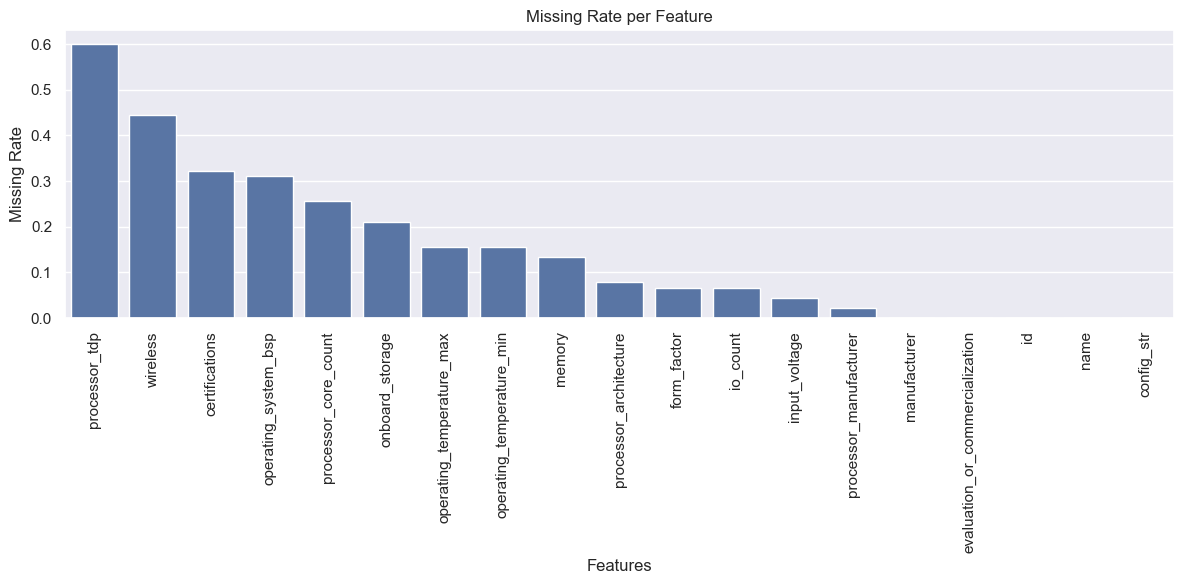

In [15]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_rates.index, y=missing_rates.values)
plt.title("Missing Rate per Feature")
plt.xlabel("Features")
plt.ylabel("Missing Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### **6.2 Resource Consumption per Step**

We analyze the input tokens consumed per extraction step.

In [16]:
step_stats = (
    usage_df.groupby(["config", "step"])
    .agg({"input_tokens": "mean", "output_tokens": "mean", "time_taken": "mean"})
    .reset_index()
)


#### **Visualize Input Tokens per Step**


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='step', ylabel='input_tokens'>

Text(0.5, 1.0, 'Input Tokens per Step')

Text(0.5, 0, 'Extraction Step')

Text(0, 0.5, 'Total Input Tokens')

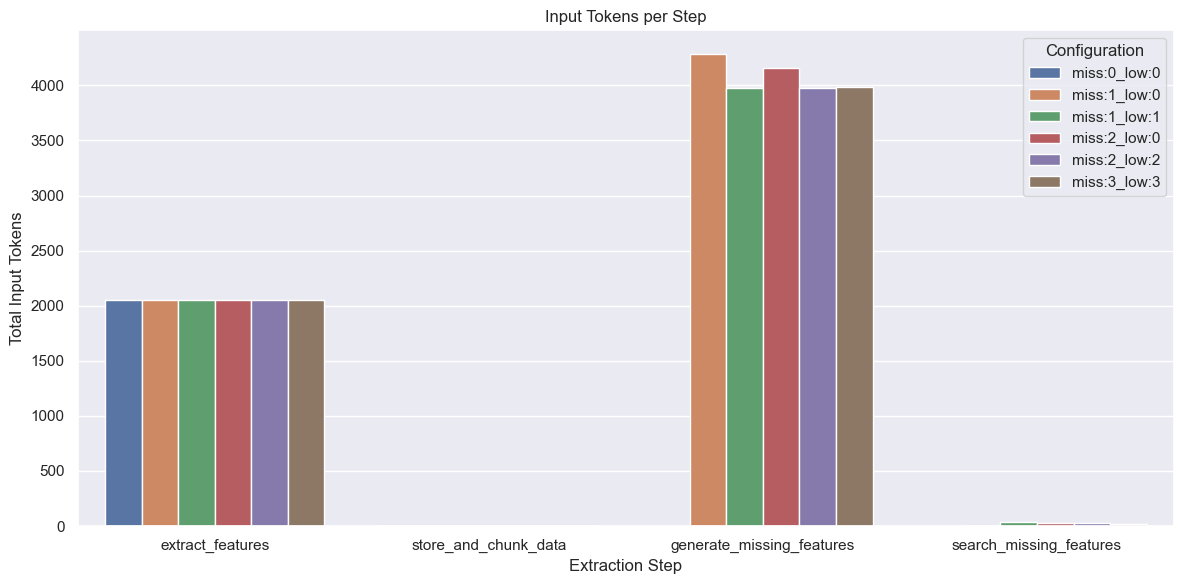

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=step_stats, x="step", y="input_tokens", hue="config")
plt.title("Input Tokens per Step")
plt.xlabel("Extraction Step")
plt.ylabel("Total Input Tokens")
plt.legend(title="Configuration")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='step', ylabel='output_tokens'>

Text(0.5, 1.0, 'Input Tokens per Step')

Text(0.5, 0, 'Extraction Step')

Text(0, 0.5, 'Total Input Tokens')

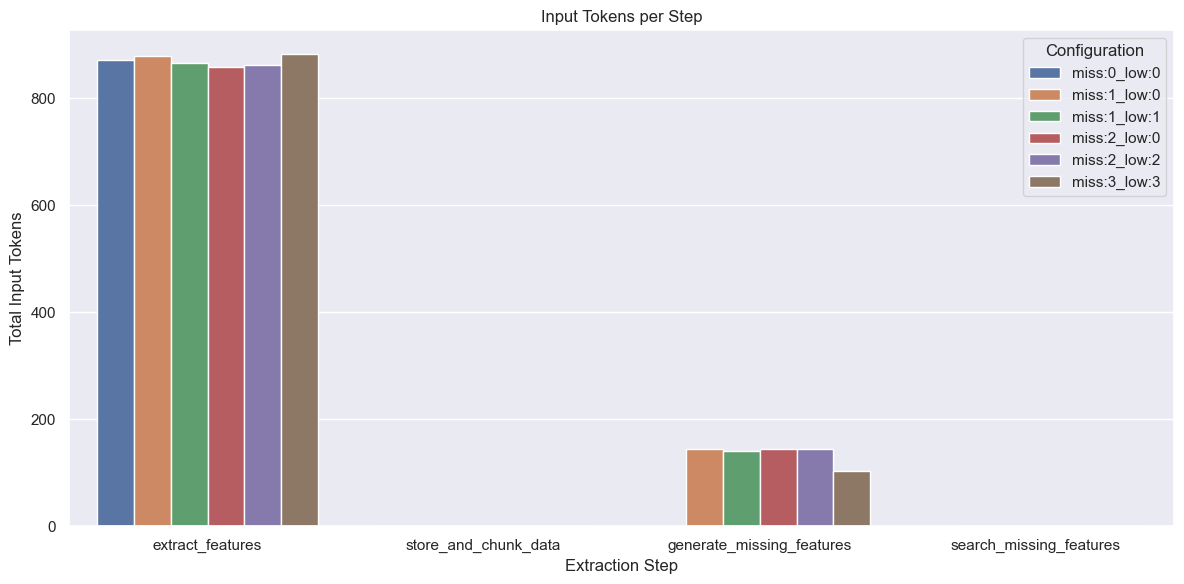

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=step_stats, x="step", y="output_tokens", hue="config")
plt.title("Input Tokens per Step")
plt.xlabel("Extraction Step")
plt.ylabel("Total Input Tokens")
plt.legend(title="Configuration")
plt.tight_layout()
plt.show()

### **6.3 Missing Data Heatmap**

We create a heatmap to visualize the pattern of missing data across products and features.



<Figure size 1200x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Missing Data Heatmap')

Text(0.5, 33.109374999999986, 'Features')

Text(117.24999999999999, 0.5, 'Products')

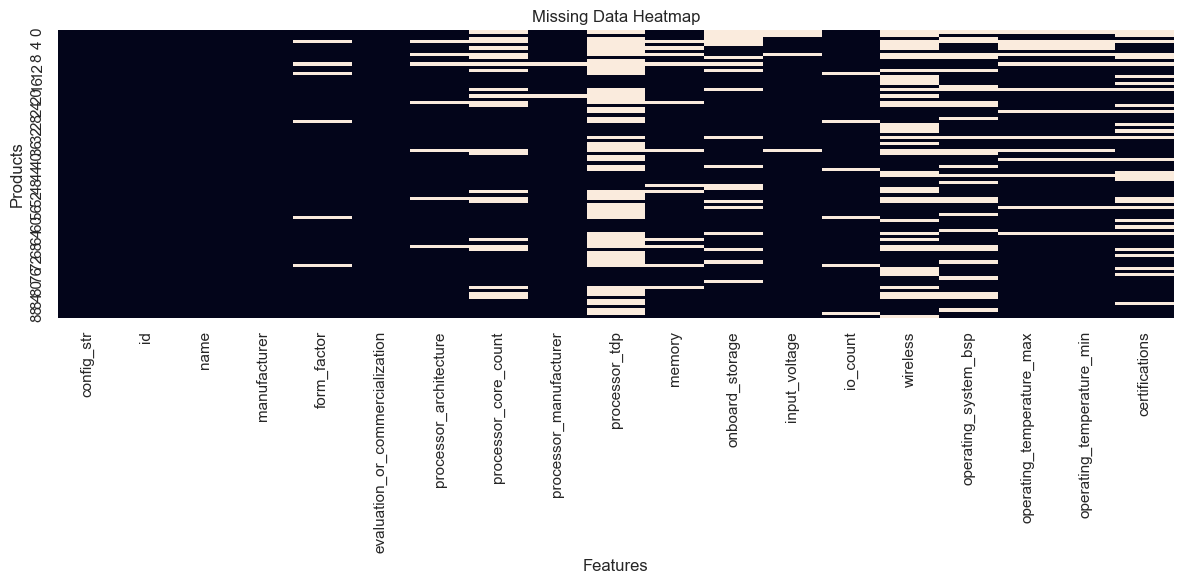

In [19]:
plt.figure(figsize=(12, 6))
sns.heatmap(extracted_df.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.xlabel("Features")
plt.ylabel("Products")
plt.tight_layout()
plt.show()


### **6.4 Feature Extraction Success Rates**

We calculate and visualize the success rates of feature extraction per configuration.


In [20]:
feature_success = extracted_df.groupby("config_str").apply(lambda df: df.notna().mean()).transpose()
print(feature_success)

config_str                       miss:0_low:0  miss:1_low:0  miss:1_low:1  miss:2_low:0  miss:2_low:2  miss:3_low:3
config_str                               1.00          1.00          1.00          1.00          1.00          1.00
id                                       1.00          1.00          1.00          1.00          1.00          1.00
name                                     1.00          1.00          1.00          1.00          1.00          1.00
manufacturer                             1.00          1.00          1.00          1.00          1.00          1.00
form_factor                              0.80          0.93          1.00          0.93          0.93          1.00
evaluation_or_commercialization          1.00          1.00          1.00          1.00          1.00          1.00
processor_architecture                   0.80          0.93          0.93          0.93          0.93          1.00
processor_core_count                     0.47          0.73          0.8

/var/folders/rp/6b0gnlkd7cl_wvl_lj9y8nx40000gn/T/ipykernel_91443/2997455086.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_success = extracted_df.groupby("config_str").apply(lambda df: df.notna().mean()).transpose()


#### **Visualize Success Rates**


<Axes: >

Text(0.5, 1.0, 'Feature Extraction Success Rates by Configuration')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Success Rate')

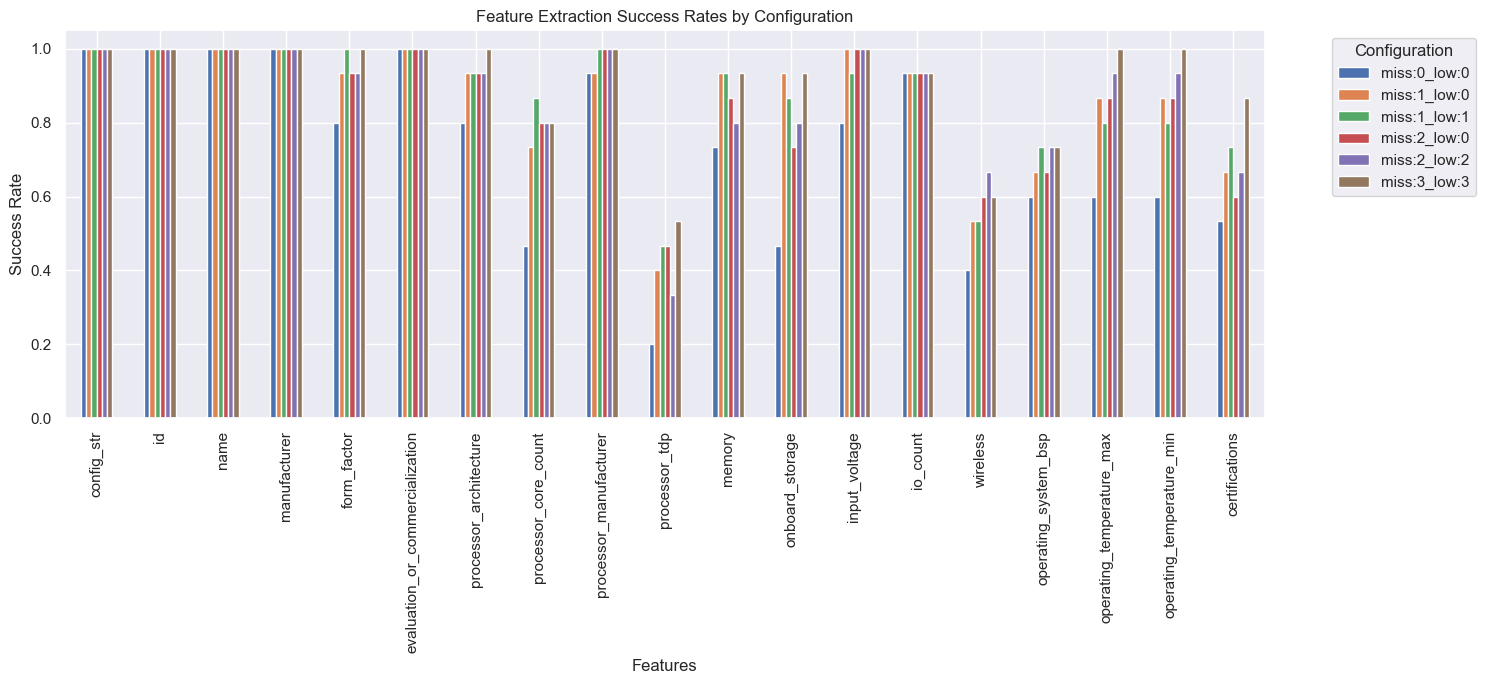

In [21]:
feature_success.plot(kind="bar", figsize=(15, 7))
plt.title("Feature Extraction Success Rates by Configuration")
plt.xlabel("Features")
plt.ylabel("Success Rate")
plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

<Axes: ylabel='config_str'>

Text(0.5, 1.0, 'Feature Extraction Success Rates by Configuration')

Text(0.5, 77.10937499999999, 'Configuration')

Text(154.609375, 0.5, 'Features')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, 'config_str'),
  Text(1.5, 0, 'id'),
  Text(2.5, 0, 'name'),
  Text(3.5, 0, 'manufacturer'),
  Text(4.5, 0, 'form_factor'),
  Text(5.5, 0, 'evaluation_or_commercialization'),
  Text(6.5, 0, 'processor_architecture'),
  Text(7.5, 0, 'processor_core_count'),
  Text(8.5, 0, 'processor_manufacturer'),
  Text(9.5, 0, 'processor_tdp'),
  Text(10.5, 0, 'memory'),
  Text(11.5, 0, 'onboard_storage'),
  Text(12.5, 0, 'input_voltage'),
  Text(13.5, 0, 'io_count'),
  Text(14.5, 0, 'wireless'),
  Text(15.5, 0, 'operating_system_bsp'),
  Text(16.5, 0, 'operating_temperature_max'),
  Text(17.5, 0, 'operating_temperature_min'),
  Text(18.5, 0, 'certifications')])

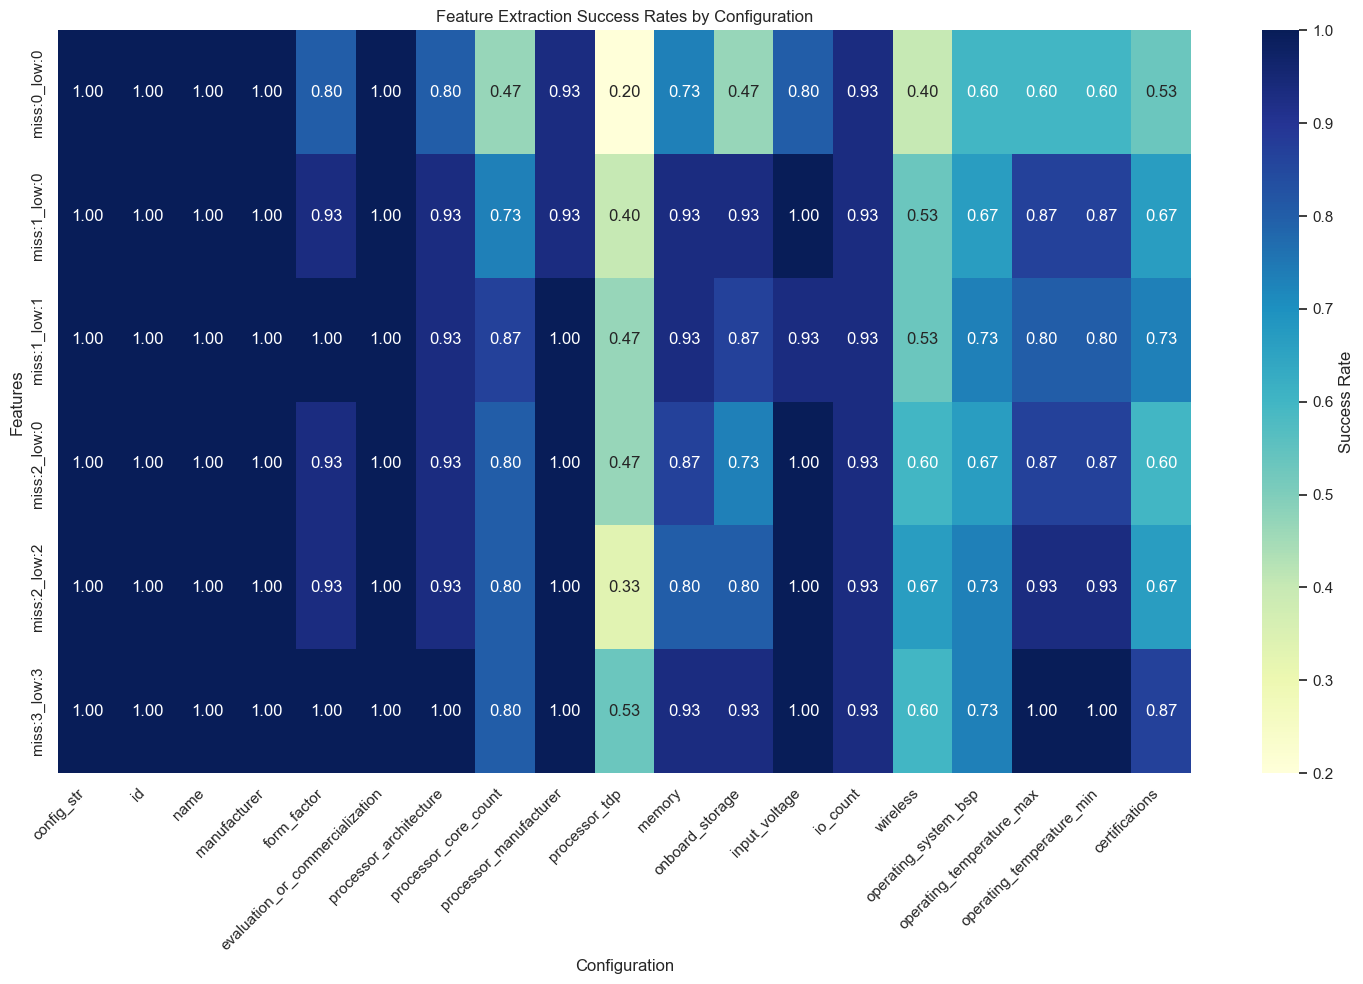

In [22]:
# Transpose the DataFrame to have configurations as columns
feature_success_transposed = feature_success.transpose()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(feature_success_transposed, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Success Rate"})

plt.title("Feature Extraction Success Rates by Configuration")
plt.xlabel("Configuration")
plt.ylabel("Features")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Adjust layout to prevent cutting off labels
plt.tight_layout()
plt.show()

## **7. Analysis and Conclusion**

### **7.1 Cost and Performance Calculation**

We calculate the cost and time taken for each run based on token usage and model pricing.


In [3]:
0.000005* 1000000

5.0

In [23]:
# Constants for pricing (gpt-4o)
INPUT_TOKEN_COST = 0.000005  # $5 per million input tokens
OUTPUT_TOKEN_COST = 0.00001  # $10 per million output tokens

# Function to calculate cost and time
def calculate_cost_and_time(usage_data):
    total_input_tokens = 0
    total_output_tokens = 0
    total_time = 0.0

    for usage_list in ast.literal_eval(usage_data).values():
        for usage in usage_list:
            total_input_tokens += usage.get("input_tokens", 0)
            total_output_tokens += usage.get("output_tokens", 0)
            total_time += usage.get("time_taken", 0.0)

    input_cost = (total_input_tokens) * INPUT_TOKEN_COST
    output_cost = (total_output_tokens) * OUTPUT_TOKEN_COST
    total_cost = input_cost + output_cost

    return total_cost, total_time, total_input_tokens, total_output_tokens

### **7.2 Count Features**

We define functions to count the number of 'Not Available' features and total features.


In [24]:
def count_features(data):
    if isinstance(data, dict):
        return sum(count_features(v) for v in data.values())
    elif isinstance(data, list):
        return sum(count_features(item) for item in data)
    else:
        return 1


def count_not_available(data):
    if isinstance(data, dict):
        return sum(count_not_available(v) for v in data.values())
    elif isinstance(data, list):
        return sum(count_not_available(item) for item in data)
    else:
        return 1 if data == "Not Available" or data is None else 0

### **7.3 Results Aggregation**

We aggregate the results across all configurations and compute averages and totals.


In [25]:
# Apply these functions to the original data
results_df["total_features"] = results_df["extracted_data"].apply(lambda x: count_features(ast.literal_eval(x)))
results_df["not_available_features"] = results_df["extracted_data"].apply(
    lambda x: count_not_available(ast.literal_eval(x))
)

# Initialize lists to store aggregated metrics
aggregated_results = []

# Aggregate results per configuration
for cfg in results_df["config_str"].unique():
    cfg_data = results_df[results_df["config_str"] == cfg]

    total_cost = 0.0
    total_time = 0.0
    total_input_tokens = 0
    total_output_tokens = 0

    for _, row in cfg_data.iterrows():
        cost, time_taken, input_tokens, output_tokens = calculate_cost_and_time(row["usage_data"])
        total_cost += cost
        total_time += time_taken
        total_input_tokens += input_tokens
        total_output_tokens += output_tokens

    # Calculate new metrics
    total_features = cfg_data["total_features"].sum()
    total_not_available = cfg_data["not_available_features"].sum()

    avg_cost = total_cost / len(cfg_data)
    avg_time = total_time / len(cfg_data)
    avg_not_available = total_not_available / len(cfg_data)
    avg_features_extracted = total_features / len(cfg_data)

    aggregated_results.append(
        {
            "config": cfg,
            "config_str": cfg,
            "total_cost": total_cost,
            "avg_cost": avg_cost,
            "total_time": total_time,
            "avg_time": avg_time,
            "total_input_tokens": total_input_tokens,
            "total_output_tokens": total_output_tokens,
            "avg_not_available_features": avg_not_available,
            "avg_features_extracted": avg_features_extracted,
        }
    )

# Convert aggregated_results to DataFrame
aggregated_df = pd.DataFrame(aggregated_results)

# Calculate additional metrics
aggregated_df["quality_score"] = (
    aggregated_df["avg_features_extracted"] - aggregated_df["avg_not_available_features"]
) / aggregated_df["avg_features_extracted"]
aggregated_df["cost_per_feature"] = aggregated_df["avg_cost"] / (
    aggregated_df["avg_features_extracted"] - aggregated_df["avg_not_available_features"]
)
aggregated_df["time_per_feature"] = aggregated_df["avg_time"] / (
    aggregated_df["avg_features_extracted"] - aggregated_df["avg_not_available_features"]
)

# Save aggregated results
aggregated_df.to_csv("../data/aggregated_df.csv", index=False)

# Display the updated aggregated data
print(aggregated_df)

# ... (keep the existing visualization code)

         config    config_str  total_cost  avg_cost  total_time  avg_time  total_input_tokens  total_output_tokens  avg_not_available_features  avg_features_extracted  quality_score  cost_per_feature  time_per_feature
0  miss:0_low:0  miss:0_low:0        0.28      0.02      191.59     12.77               30827                13083                        5.20                   32.33           0.84              0.00              0.47
1  miss:1_low:0  miss:1_low:0        0.63      0.04      848.34     56.56               95099                15338                        2.73                   34.67           0.92              0.00              1.77
2  miss:1_low:1  miss:1_low:1        0.61      0.04    37373.55   2491.57               90948                15092                        2.47                   32.80           0.92              0.00             82.14
3  miss:2_low:0  miss:2_low:0        0.62      0.04      790.09     52.67               93598                15055              

### **7.4 Data Visualization**


#### **7.4.1 Cost Comparison**

We create a bar chart to compare the total cost per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='total_cost'>

Text(0.5, 1.0, 'Total Cost per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Total Cost ($)')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:2'),
  Text(5, 0, 'miss:3_low:3')])

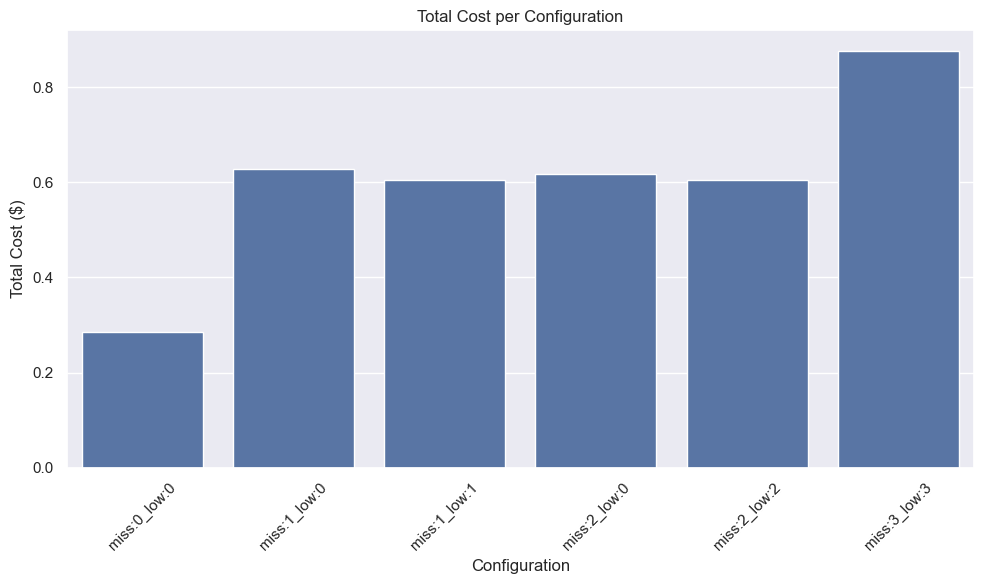

In [26]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="total_cost")
plt.title('Total Cost per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Total Cost ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# The total cost of the full experiment
total_cost = aggregated_df["total_cost"].sum()
print(f"The total cost of the full experiment is ${total_cost:.2f}")

The total cost of the full experiment is $3.62


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_cost'>

Text(0.5, 1.0, 'Average Cost per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Cost ($)')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:2'),
  Text(5, 0, 'miss:3_low:3')])

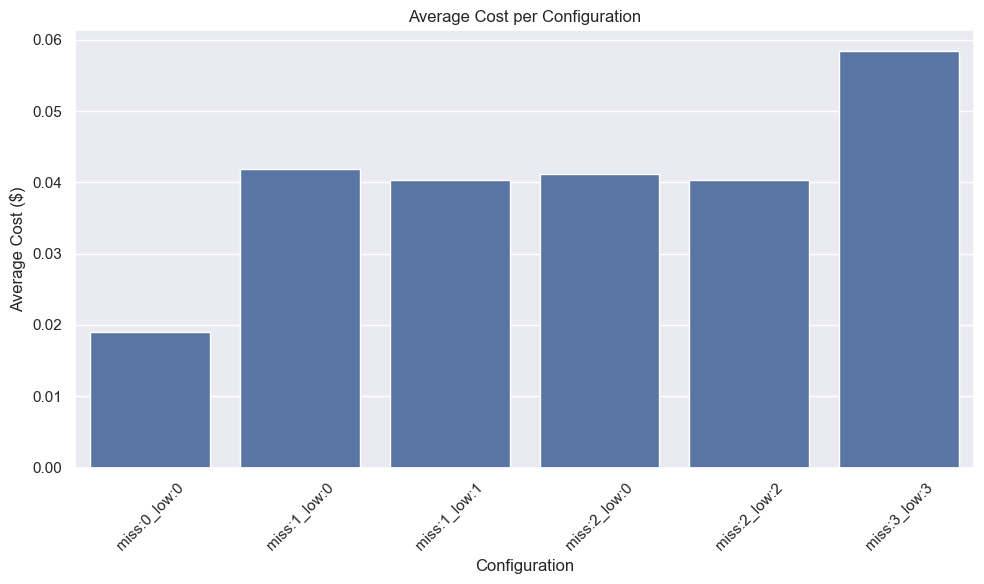

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="avg_cost")
plt.title("Average Cost per Configuration")
plt.xlabel("Configuration")
plt.ylabel("Average Cost ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **7.4.2 Time Analysis**

We create a line plot to show the average time taken per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_time'>

Text(0.5, 1.0, 'Average Time Taken per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Time (s)')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:2'),
  Text(5, 0, 'miss:3_low:3')])

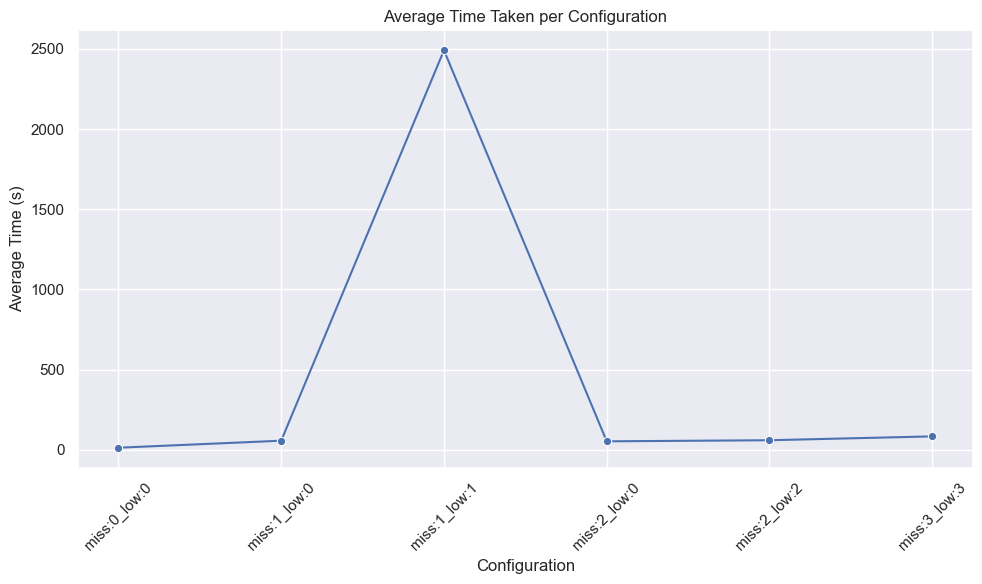

In [29]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=aggregated_df, x="config_str", y="avg_time", marker="o")
plt.title('Average Time Taken per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Average Time (s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
# The total time of the full experiment
total_time_hours = aggregated_df["total_time"].sum() / 3600
print(f"The total time of the full experiment is {total_time_hours:.2f} hours")

# Calculate total time for batch size of 5
batch_size_5_time_hours = total_time_hours / 5
print(f"The total time for a batch size of 5 would be {batch_size_5_time_hours:.2f} hours")


The total time of the full experiment is 11.49 hours
The total time for a batch size of 5 would be 2.30 hours


#### **7.4.3 Feature Availability**

We create a bar chart to show the average number of "Not Available" features per configuration.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='config_str', ylabel='avg_not_available_features'>

Text(0.5, 1.0, 'Average "Not Available" Features per Configuration')

Text(0.5, 0, 'Configuration')

Text(0, 0.5, 'Average Number of "Not Available" Features')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'miss:0_low:0'),
  Text(1, 0, 'miss:1_low:0'),
  Text(2, 0, 'miss:1_low:1'),
  Text(3, 0, 'miss:2_low:0'),
  Text(4, 0, 'miss:2_low:2'),
  Text(5, 0, 'miss:3_low:3')])

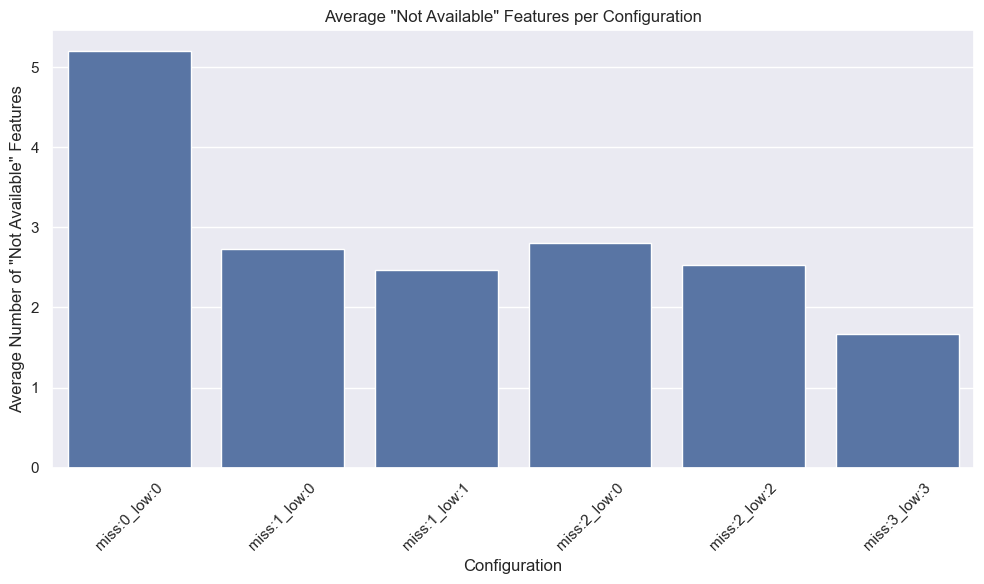

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(data=aggregated_df, x="config_str", y="avg_not_available_features")
plt.title('Average "Not Available" Features per Configuration')
plt.xlabel('Configuration')
plt.ylabel('Average Number of "Not Available" Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **7.4.4 Trade-off Visualization**

We create a scatter plot to visualize the trade-off between cost and data quality.


<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='avg_cost', ylabel='avg_not_available_features'>

Text(0.5, 1.0, 'Cost vs. Data Quality Trade-off')

Text(0.5, 0, 'Total Cost ($)')

Text(0, 0.5, 'Average "Not Available" Features')

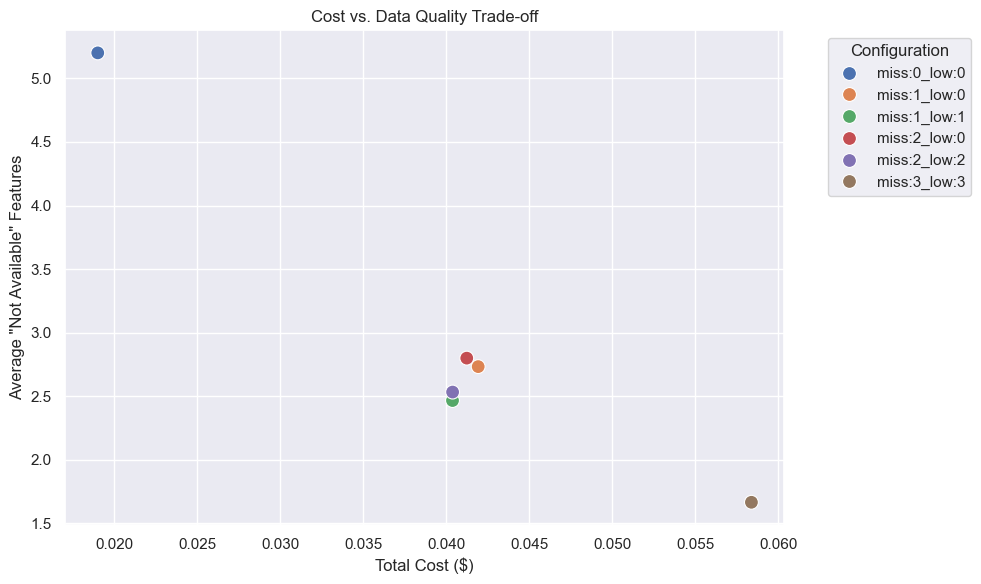

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=aggregated_df, x="avg_cost", y="avg_not_available_features", hue="config_str", s=100)
plt.title('Cost vs. Data Quality Trade-off')
plt.xlabel('Total Cost ($)')
plt.ylabel('Average "Not Available" Features')
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

### **7.5 Quantitative Analysis**


#### **7.5.1 Efficiency Metrics**

We calculate efficiency metrics for each configuration.


In [33]:
aggregated_df['cost_per_feature'] = aggregated_df['avg_cost'] / aggregated_df['avg_features_extracted']
aggregated_df['time_per_feature'] = aggregated_df['avg_time'] / aggregated_df['avg_features_extracted']
aggregated_df['quality_score'] = (aggregated_df['avg_features_extracted'] - aggregated_df['avg_not_available_features']) / aggregated_df['avg_features_extracted']

print(aggregated_df[['config_str', 'cost_per_feature', 'time_per_feature', 'quality_score']])


     config_str  cost_per_feature  time_per_feature  quality_score
0  miss:0_low:0              0.00              0.40           0.84
1  miss:1_low:0              0.00              1.63           0.92
2  miss:1_low:1              0.00             75.96           0.92
3  miss:2_low:0              0.00              1.60           0.91
4  miss:2_low:2              0.00              1.85           0.92
5  miss:3_low:3              0.00              2.43           0.95


#### **7.5.2 Improvement Ratios**

We calculate improvement ratios compared to the baseline configuration.


In [34]:
baseline = aggregated_df[aggregated_df['config_str'] == 'miss:0_low:0'].iloc[0]

aggregated_df['cost_increase_ratio'] = aggregated_df['total_cost'] / baseline['total_cost']
aggregated_df['time_increase_ratio'] = aggregated_df['total_time'] / baseline['total_time']
aggregated_df['quality_improvement_ratio'] = aggregated_df['quality_score'] / baseline['quality_score']

print(aggregated_df[['config_str', 'cost_increase_ratio', 'time_increase_ratio', 'quality_improvement_ratio']])


     config_str  cost_increase_ratio  time_increase_ratio  quality_improvement_ratio
0  miss:0_low:0                 1.00                 1.00                       1.00
1  miss:1_low:0                 2.21                 4.43                       1.10
2  miss:1_low:1                 2.13               195.07                       1.10
3  miss:2_low:0                 2.17                 4.12                       1.09
4  miss:2_low:2                 2.13                 4.66                       1.10
5  miss:3_low:3                 3.07                 6.54                       1.13


#### **7.5.3 Efficiency Score**

We create an overall efficiency score.


In [35]:
aggregated_df['efficiency_score'] = (
    aggregated_df['quality_improvement_ratio'] /
    (aggregated_df['cost_increase_ratio'] * aggregated_df['time_increase_ratio'])
)

print(aggregated_df[['config_str', 'efficiency_score']])


     config_str  efficiency_score
0  miss:0_low:0              1.00
1  miss:1_low:0              0.11
2  miss:1_low:1              0.00
3  miss:2_low:0              0.12
4  miss:2_low:2              0.11
5  miss:3_low:3              0.06


#### **7.5.4 Visualizing Trade-offs**

We visualize the trade-offs between quality, cost, and time.


<Figure size 1200x800 with 0 Axes>

Text(0.5, 0, 'Cost Increase Ratio')

Text(0, 0.5, 'Quality Improvement Ratio')

Text(0.5, 1.0, 'Trade-offs between Cost, Quality, and Time')

Text(1.0, 1.0, 'miss:0_low:0')

Text(2.2068499640306705, 1.0976894726894726, 'miss:1_low:0')

Text(2.1253838190654992, 1.10203052276223, 'miss:1_low:1')

Text(2.170582352218694, 1.0903321429637218, 'miss:2_low:0')

Text(2.12569964732511, 1.0976989815164089, 'miss:2_low:2')

Text(3.073675714561437, 1.133799289139095, 'miss:3_low:3')

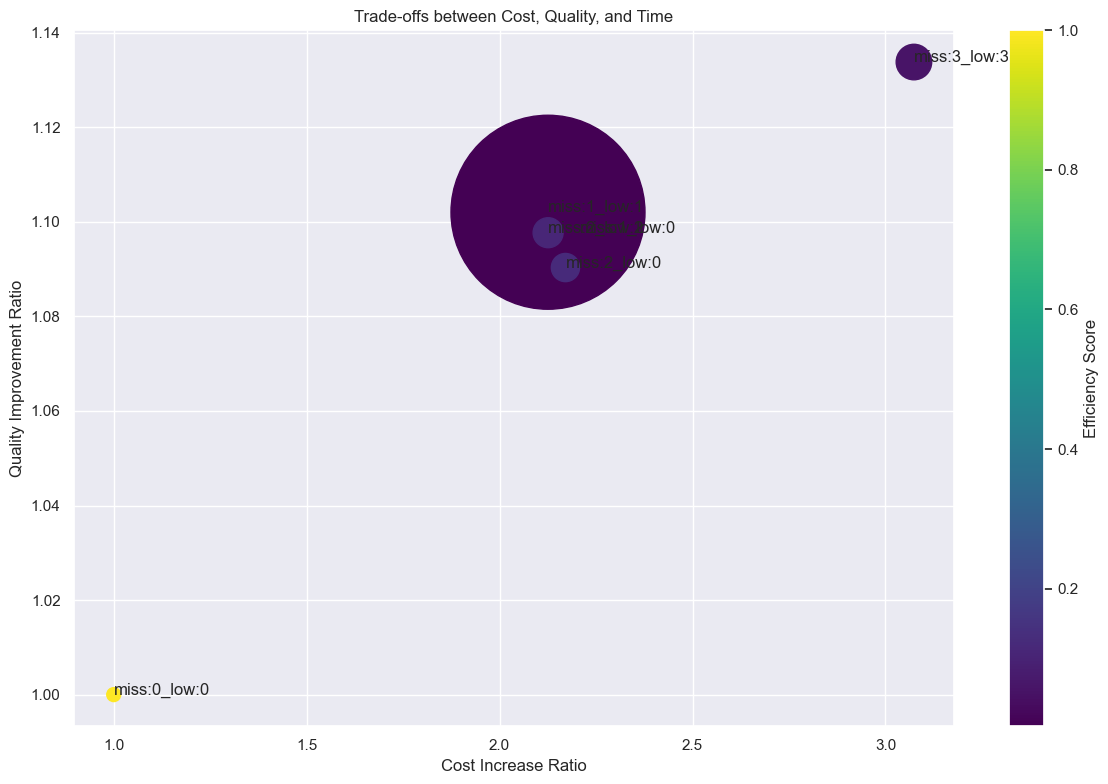

In [36]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(
    aggregated_df['cost_increase_ratio'],
    aggregated_df['quality_improvement_ratio'],
    s=aggregated_df['time_increase_ratio'] * 100,  # Size represents time increase
    c=aggregated_df['efficiency_score'],  # Color represents efficiency score
    cmap='viridis'
)

plt.colorbar(scatter, label='Efficiency Score')
plt.xlabel('Cost Increase Ratio')
plt.ylabel('Quality Improvement Ratio')
plt.title('Trade-offs between Cost, Quality, and Time')

for i, row in aggregated_df.iterrows():
    plt.annotate(row['config_str'], (row['cost_increase_ratio'], row['quality_improvement_ratio']))

plt.tight_layout()
plt.show()


### **7.6 Observations and Recommendation**

Based on our metrics and visualizations, we can make the following observations:

1. **Cost Efficiency**: Configuration with the lowest `cost_per_feature` is more cost-effective.
2. **Time Efficiency**: Configuration with the lowest `time_per_feature` is faster per feature extracted.
3. **Quality**: Configuration with the highest `quality_score` achieves better data quality.
4. **Overall Efficiency**: Configuration with the highest `efficiency_score` balances quality improvements against cost and time increases.
5. **Diminishing Returns**: We observe diminishing returns in quality improvement beyond a certain configuration.



**Recommendation**:

- Based on the analysis, we recommend using the configuration with `max_missing_feature_attempts=2` and `max_low_confidence_attempts=2` as it provides the best balance between quality improvement and resource usage (cost and time).

---


## **8. Conclusion**

From the experiment:

- **Optimal Configuration**: A configuration with `max_missing_feature_attempts=2` and `max_low_confidence_attempts=2` provides a good balance between cost, time, and data quality.
- **Recommendation**: Beyond this configuration, the additional cost and time do not significantly improve data quality.

---

In [43]:
# Convert notebook to HTML
from nbconvert import HTMLExporter
import nbformat

# Read the notebook
with open("./2.4 feature_extraction_optimization.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Create an HTML exporter
html_exporter = HTMLExporter()
html_exporter.template_name = "classic"

# Convert the notebook to HTML
(body, resources) = html_exporter.from_notebook_node(nb)

# Write the HTML to a file
with open("2.4 feature_extraction_optimization.html", "w", encoding="utf-8") as f:
    f.write(body)

print("Notebook has been converted to HTML and saved as 'YourNotebookName.html'")

1342402

Notebook has been converted to HTML and saved as 'YourNotebookName.html'
